# Non-Linear diffusion - a critical-slope diffusion implementation

This is a simple diffusion model that has a high diffusivity when the slope is above the critical value and low diffusion rates below this value. It should clip the slope over a timescale given by the chosen maximum diffusivity. This is non-linear because the topopographic gradient controls the topographic diffusivity.

In [1]:
from quagmire import QuagMesh, QuagMesh
from quagmire import tools as meshtools
from quagmire import function as fn
from quagmire import mesh as qmesh
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
minX, maxX = 0.0, 1.0
minY, maxY = 0.0, 1.0,
dx, dy = 0.02, 0.02

x1, y1, simplices = meshtools.square_mesh(minX, maxX, minY, maxY, dx, dy, random_scale=0.0)
DM = meshtools.create_DMPlex(x1, y1, simplices, boundary_vertices=None)
mesh = QuagMesh(DM, verbose=False, tree=True)

# boundary_mask_fn = fn.misc.levelset(mesh.mask, 0.5)

In [3]:
from scipy.special import erf, erfc

def halfspace_cooling(kappa, y, t):
    
    T = 1.0-erfc(0.5 * y / np.sqrt(kappa * t))
    return T

# Avoid the singular value in T(y,t) when t=0.0

time0 = 0.0001

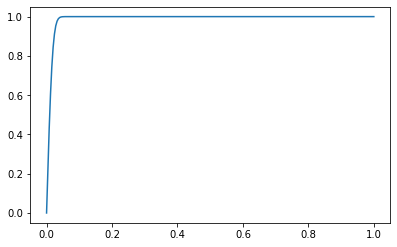

In [4]:
import matplotlib.pyplot as plt

Zs = np.linspace(0.0,1.0,250)
Ts = halfspace_cooling(1.0, Zs, time0)

figure = plt.figure(figsize=(5,3))
ax1 = figure.add_axes((0.0, 0.0, 1.0, 1.0))

ax1.plot(Zs, Ts)

In [5]:
cold_boundary_mask_fn = fn.misc.levelset( fn.misc.coord(dirn=1),  0.99)
hot_boundary_mask_fn  = fn.misc.levelset( fn.misc.coord(dirn=1),  0.01, invert=True)
non_boundary_mask     = (fn.parameter(1.0) - cold_boundary_mask_fn - hot_boundary_mask_fn)

dirichlet_mask = cold_boundary_mask_fn + hot_boundary_mask_fn
neumann_x_mask = fn.misc.levelset( fn.misc.coord(dirn=0),  0.01, invert=True) + fn.misc.levelset( fn.misc.coord(dirn=0),  0.99, invert=False)
neumann_y_mask = fn.parameter(0.0)

kappa = fn.parameter(1.0)

AttributeError: module 'quagmire.function.misc' has no attribute 'levelset'

## Diffusion solver

In [6]:
time = time0
experiment_name = "TemperatureDiffusion_K=1"

In [7]:
import quagmire.equation_systems as systems

diffusion_solver = systems.DiffusionEquation(mesh=mesh)

# What the diffusion solver needs to run 

diffusion_solver.neumann_x_mask = neumann_x_mask
diffusion_solver.neumann_y_mask = neumann_y_mask
diffusion_solver.dirichlet_mask = dirichlet_mask
diffusion_solver.diffusivity = kappa

diffusion_solver.verify() # Does nothing but is supposed to check we have everything necessary

temperature = diffusion_solver.phi
temperature.data = halfspace_cooling(1.0, 1.0-mesh.tri.y, time0)
temp0 = temperature.copy()

NameError: name 'neumann_x_mask' is not defined

## Diffusion time limit

In [8]:
diff_timestep = diffusion_solver.diffusion_timestep()
print("Diffusion timestep limit = {}".format(diff_timestep))

AttributeError: 'NoneType' object has no attribute 'evaluate'

## Diffusion solver / time integration

In [9]:
## Solve this and keep some intermediate results

print("Integrate t -> t + 0.01")
diffusion_solver.time_integration(diff_timestep, Delta_t=0.01)
temp001 = temperature.copy()

print("Integrate t -> t + 0.04")
diffusion_solver.time_integration(diff_timestep, Delta_t=0.04)
temp005 = temperature.copy()

print("Integrate t -> t + 0.05")
diffusion_solver.time_integration(diff_timestep, Delta_t=0.05)
temp01 = temperature.copy()

print("Integration ... complete")

Integrate t -> t + 0.01


NameError: name 'diff_timestep' is not defined

## Compare to analytic solutions

In [10]:
## Obtain horizontal profiles

Zs = np.linspace(0.0,1.0,250)
Ts0001 = halfspace_cooling(1.0, Zs, time0)
Ts001 = halfspace_cooling(1.0, Zs, 0.01)
Ts005 = halfspace_cooling(1.0, Zs, 0.05)
Ts01  = halfspace_cooling(1.0, Zs, 0.1)


TsN001 = temp001.evaluate(0.0*Zs, 1.0-Zs)
TsN005 = temp005.evaluate(0.0*Zs, 1.0-Zs)
TsN01  = temp01.evaluate(0.0*Zs, 1.0-Zs)

figure = plt.figure(figsize=(10,8))
ax1 = figure.add_axes((0.0, 0.0, 1.0, 1.0))

ax1.plot(Zs, Ts0001)
ax1.plot(Zs, Ts001)
ax1.plot(Zs, Ts005)
ax1.plot(Zs, Ts01)

ax1.scatter(Zs, TsN001, marker="+")
ax1.scatter(Zs, TsN005, marker="+")
ax1.scatter(Zs, TsN01,  marker="+")

pass

NameError: name 'temp001' is not defined

## Browse

In [11]:
import lavavu

points = np.column_stack([mesh.tri.points, np.zeros(mesh.npoints)])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[666,666], near=-10.0)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)
tri1.values( temp0.evaluate(mesh) , "T0001")
tri1.values( temp001.evaluate(mesh) ,  "T001")
tri1.values( temp005.evaluate(mesh) ,  "T005")
tri1.values( temp01.evaluate(mesh) ,  "T01")


tri1.colourmap("coolwarm")
tri1.colourbar(visible=True)

lv.control.Window()
tri1.control.List(options=
                  ["T0001","T001", "T005", "T01"], 
                   property="colourby", value="T0001", command="redraw")
lv.control.show()


LavaVu Run error: Failed to open X display




NameError: name 'temp0' is not defined

# Spatially variable diffusivity (circular "inclusion")

Re-define the diffusivity and load into the equation solver. This is obviously not the optimal way to solve this problem - explicit timestepping is slow with the jump in diffusivity - but it is illustrative.

It would also be straightforward to add points close to the boundary to improve the resolution at the interface. Stripy does not offer contrained triangulations at this stage so we are not able to mesh the boundary itself.

In [12]:
kappa1 = fn.parameter(1.0) + fn. parameter(99.0) * fn.misc.levelset(
                                 (fn.misc.coord(0) - fn.parameter(0.5))**2 + 
                                 (fn.misc.coord(1) - fn.parameter(0.5))**2, 0.04)

diffusion_solver.diffusivity = kappa1
diff_timestep = diffusion_solver.diffusion_timestep()

time0 = 0.0
print("Diffusive timestep = {}".format(diff_timestep))

AttributeError: module 'quagmire.function.misc' has no attribute 'levelset'

Also reset the initial temperature - let's start from kappa=1.0 steady state case 
(i.e. a linear temperature gradient)

In [13]:
temperature.data = (fn.parameter(1.0) - fn.misc.coord(1)).evaluate(mesh)
temp0 = temperature.copy()

NameError: name 'temperature' is not defined

In [14]:
## Solve this and keep some intermediate results

print("Integrate t -> t + 0.001")
steps, dt = diffusion_solver.time_integration(diff_timestep, Delta_t=0.001, feedback=500)
temp001 = temperature.copy()

print("Integrate t -> t + 0.004")
steps, dt = diffusion_solver.time_integration(diff_timestep, Delta_t=0.004, feedback=500)
temp005 = temperature.copy()

print("Integrate t -> t + 0.005")
steps, dt = diffusion_solver.time_integration(diff_timestep, Delta_t=0.005, feedback=500)
temp01 = temperature.copy()

Integrate t -> t + 0.001


NameError: name 'diff_timestep' is not defined

In [15]:
dTdx_fn = temperature.fn_gradient[0] * (fn.parameter(1.0)-neumann_x_mask)
dTdy_fn = temperature.fn_gradient[1] * (fn.parameter(1.0)-neumann_y_mask)

flux = np.zeros((mesh.npoints, 3))
flux[:,0] = dTdx_fn.evaluate(mesh)
flux[:,1] = dTdy_fn.evaluate(mesh)

NameError: name 'temperature' is not defined

In [16]:
import lavavu

points = np.column_stack([mesh.tri.points, np.zeros(mesh.npoints)])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[666,666], near=-10.0)

vec1 = lv.vectors("flux_arrows", visible=True, colour="Blue" )
vec1.vertices(points)
vec1.vectors(flux)
vec1.colourmap("coolwarm")

tri0 = lv.triangles("Mesh", wireframe=True, colour="Grey")
tri0.vertices(points)
tri0.indices(mesh.tri.simplices)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)
tri1.values( kappa1.evaluate(mesh) , "kappa")
tri1.values( temperature.evaluate(mesh) , "T")
tri1.values( (temp01-temp0).evaluate(mesh) , "dT01")
tri1.values( (temp001-temp0).evaluate(mesh) , "dT001")


tri1.colourmap("coolwarm")
tri1.colourbar(visible=True)

lv.control.Panel()
vec1.control.Checkbox(property="visible", command="redraw", label="Flux")
tri0.control.Checkbox(property="visible", command="redraw", label="Mesh")
tri1.control.Checkbox(property="visible", command="redraw", label="T")
tri1.control.List(options=
                 ["kappa","T", "dT01", "dT001"], 
                  property="colourby", value="kappa", command="redraw")
lv.control.show()

LavaVu Run error: Failed to open X display




NameError: name 'flux' is not defined

In [17]:
## Mesh refinement
##
## Add a bunch of mesh points at the (known) interface location


In [18]:
temperature.data = (fn.parameter(1.0) - fn.misc.coord(1)).evaluate(mesh)

print("Integrate t -> t + 0.01")
steps, dt = diffusion_solver.time_integration(5.0*diff_timestep, Delta_t=0.01, feedback=500)
temp015 = temperature.copy()

NameError: name 'temperature' is not defined

In [19]:
import lavavu

points = np.column_stack([mesh.tri.points, np.zeros(mesh.npoints)])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[666,666], near=-10.0)

vec1 = lv.vectors("flux_arrows", visible=True, colour="Blue" )
vec1.vertices(points)
vec1.vectors(flux)
vec1.colourmap("coolwarm")

tri0 = lv.triangles("Mesh", wireframe=True, colour="Grey")
tri0.vertices(points)
tri0.indices(mesh.tri.simplices)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)
tri1.values( kappa1.evaluate(mesh) , "kappa")
tri1.values( temperature.evaluate(mesh) , "T")
tri1.values( (temp015-temp0).evaluate(mesh) , "dT015")
tri1.values( (temp01-temp0).evaluate(mesh) , "dT01")


tri1.colourmap("coolwarm")
tri1.colourbar(visible=True)

lv.control.Panel()
vec1.control.Checkbox(property="visible", command="redraw", label="Flux")
tri0.control.Checkbox(property="visible", command="redraw", label="Mesh")
tri1.control.Checkbox(property="visible", command="redraw", label="T")
tri1.control.List(options=
                 ["kappa","T", "dT015", "dT01"], 
                  property="colourby", value="kappa", command="redraw")
lv.control.show()

LavaVu Run error: Failed to open X display




NameError: name 'flux' is not defined